In [71]:
# You have to install pydotplus using homebrew instead of pip, which would raise error.
# https://blog.csdn.net/coder_Gray/article/details/81632003

In [70]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from IPython.core.display import Image
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import pydotplus
from io import StringIO

In [68]:
data = pd.read_csv('Bike-Sharing-Dataset/day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [47]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [48]:
data_xgb = data[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt']]

In [49]:
cols = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit']
data_xgb[cols] = data_xgb[cols].astype(object)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [50]:
data_xgb_use = pd.get_dummies(data_xgb)
data_xgb_use.head()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3
0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
1,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
2,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0
4,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0


In [51]:
# already tuned parameters
n_estimators = 100
max_depth = 4
subsample = .9
learning_rate = .1

In [52]:
X = data_xgb_use.drop(columns=['cnt'])
y = data_xgb_use[['cnt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=101)

In [53]:
clf = XGBRegressor(
    n_estimators=n_estimators,
    max_depth = max_depth,
    subsample = subsample,
    learning_rate = .3
)
clf.fit(X_train, y_train)
y_test_pre = clf.predict(X_test)
metrics.r2_score(y_test, y_test_pre)

0.9175660398716646

In [54]:
data_xgb_use['cnt_pre_xgb'] = clf.predict(X)

In [55]:
data_xgb_use.columns

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt', 'season_1', 'season_2',
       'season_3', 'season_4', 'yr_0', 'yr_1', 'mnth_1', 'mnth_2', 'mnth_3',
       'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'mnth_11', 'mnth_12', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'workingday_0', 'workingday_1', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'cnt_pre_xgb'],
      dtype='object')

In [56]:
data_white_tree = data_xgb_use.copy()
X_white_tree = data_white_tree.drop(columns=['cnt', 'cnt_pre_xgb'])
y_white_tree = data_white_tree[['cnt_pre_xgb']]

X_white_tree = data[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
y_white_tree = data_xgb_use[['cnt_pre_xgb']]

X_train, X_test, y_train, y_test = train_test_split(X_white_tree, y_white_tree, test_size=.2, random_state=101)

white_tree = DecisionTreeRegressor(max_depth=3)
white_tree.fit(X_train, y_train)
metrics.r2_score(y_test, white_tree.predict(X_test))

0.8446296162465667

In [58]:
dot_data = StringIO()

In [59]:
tree.export_graphviz(
    white_tree, 
    out_file=dot_data, 
    feature_names=X_white_tree.columns, 
    filled=True, 
    rounded=True,
    proportion=True,
    special_characters=True,
    node_ids=True
)

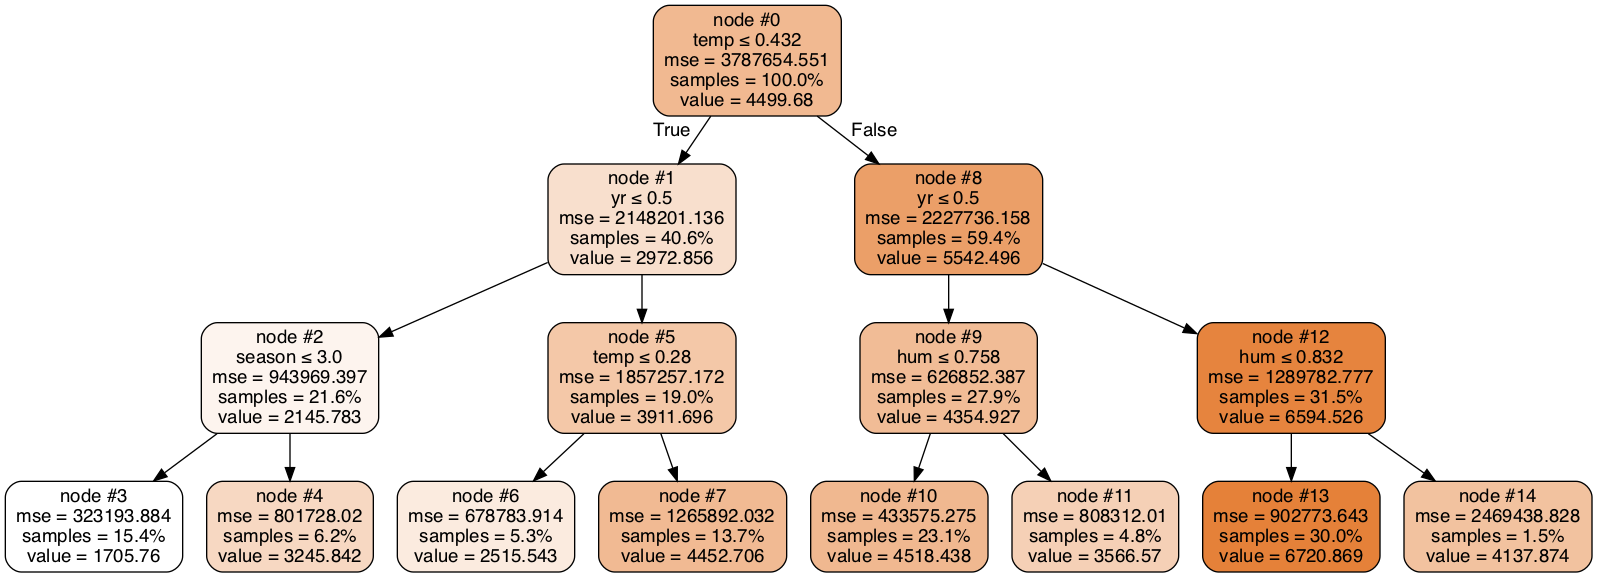

In [69]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## linear model

In [73]:
data_ols = data
data_ols['sight'] = white_tree.apply(X_white_tree)
data_ols = data_ols[['yr', 'temp', 'hum', 'sight', 'cnt']]
data_ols[['yr', 'sight']] = data_ols[['yr', 'sight']].astype(object)
data_ols_use = pd.get_dummies(data_ols, drop_first=True)
data_ols_use.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,temp,hum,cnt,yr_1,sight_4,sight_6,sight_7,sight_10,sight_11,sight_13,sight_14
0,0.344167,0.805833,985,0,0,0,0,0,0,0,0
1,0.363478,0.696087,801,0,0,0,0,0,0,0,0
2,0.196364,0.437273,1349,0,0,0,0,0,0,0,0
3,0.200000,0.590435,1562,0,0,0,0,0,0,0,0
4,0.226957,0.436957,1600,0,0,0,0,0,0,0,0


In [76]:
model_sight_ols = ols('cnt ~ temp+hum+yr_1+sight_4+sight_6+sight_7+sight_10+sight_11+sight_13+sight_14', data=data_ols_use)
est_sight_ols = model_sight_ols.fit()
est_sight_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     327.4
Date:                Mon, 05 Jul 2021   Prob (F-statistic):          7.77e-248
Time:                        15:48:59   Log-Likelihood:                -5975.2
No. Observations:                 731   AIC:                         1.197e+04
Df Residuals:                     721   BIC:                         1.202e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1980.1327    193.134     10.253      0.000    1600.961    2359.305
temp        1997.7112    355.023      5.627      0.000    1300.709    2694.713
hum        -1379.1193    255.790     -5.392      0.000   -1881.302    -876.937
yr_1        2066.7886    102.136     20.236      0.000    1866.269    2267.308
sight_4     1597.8260    151.155     10.571      0.000    1301.070    1894.582
sight_6    -1158.9692    139.124     -8.330      0.000   -1432.106    -885.833
sight_7      604.6053     96.163      6.287      0.000     415.812     793.399
sight_10    2070.1641    167.252     12.377      0.000    1741.804    2398.524
sight_11    1648.7548    193.594      8.517      0.000    1268.679    2028.830
sight_13    2275.6283    111.703     20.372      0.000    2056.326    2494.931
sight_14     345.5242    223.675      1.545      0.123     -93.608     784.657
==============================================================================
Omnibus:                       79.253   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.656
Skew:                          -0.705   Prob(JB):                     2.12e-30
Kurtosis:                       4.581   Cond. No.                     1.41e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.85e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""